In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as stats
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

import datetime as dt

%matplotlib inline

In [2]:
# Enter the begin and end dates for the gage and flow data

begin_date = '2023-01-01T00:00:00.000-05:00'
end_date = '2024-08-28T00:00:00.000-05:00'

#01473730 - Schuylkill River at Conshohocken, PA

In [3]:
#Read in raw stream gage data
gage = pd.read_csv('https://nwis.waterservices.usgs.gov/nwis/iv/?sites=01473730&parameterCd=00065&startDT='+begin_date+'&endDT='+end_date+'&siteStatus=all&format=rdb', sep='\t', skiprows=26)
gage = gage.iloc[1: , :]

In [4]:
gage['328674_00065'] = gage['328674_00065'].astype(float)
gage = gage[['datetime','328674_00065']]
gage = gage.set_index('datetime')
gage['item_id'] = 'gage'
gage  = gage.rename(columns={"328674_00065": "series"})
gage.head()

,series,item_id
datetime,,
2023-05-16 12:45,7.18,gage
2023-05-16 13:15,7.18,gage
2023-05-16 13:30,7.19,gage
2023-05-16 13:45,7.19,gage
2023-05-16 14:00,7.16,gage


In [5]:
#Read in raw flow data
flow = pd.read_csv('https://waterservices.usgs.gov/nwis/iv/?sites=01473730&parameterCd=00060&startDT='+begin_date+'&endDT='+end_date+'&siteStatus=all&format=rdb', sep='\t', skiprows=26)
flow = flow.iloc[1: , :]

In [6]:
flow['328771_00060'] = flow['328771_00060'].astype(float)
flow = flow[['datetime','328771_00060']]# Merge datasets together on datetime index and check if everything is good
flow = flow.set_index('datetime')
flow['item_id'] = 'flow'

            
#df=pd.merge(gage, flow, how='inner', left_index=True, right_index=True)
#df.head()
flow  = flow.rename(columns={"328771_00060": "series"})

flow.head()

,series,item_id
datetime,,
2023-05-16 12:45,1400.0,flow
2023-05-16 13:15,1400.0,flow
2023-05-16 13:30,1410.0,flow
2023-05-16 13:45,1410.0,flow
2023-05-16 14:00,1370.0,flow


In [7]:
merge = pd.concat([gage, flow])

In [8]:
merge

,series,item_id
datetime,,
2023-05-16 12:45,7.18,gage
2023-05-16 13:15,7.18,gage
2023-05-16 13:30,7.19,gage
2023-05-16 13:45,7.19,gage
2023-05-16 14:00,7.16,gage
...,...,...
2024-08-28 00:00,779.00,flow
2024-08-28 00:15,779.00,flow
2024-08-28 00:30,766.00,flow


In [9]:
df = merge.reset_index()

In [10]:
duplicate = df[df.duplicated()]
 
print("Duplicate Rows :")

Duplicate Rows :


In [11]:
df.drop_duplicates(subset=duplicate, inplace=True) #, 

In [12]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [13]:
df = df.set_index('datetime')

In [14]:
df.reset_index(inplace=True)

In [15]:
df

,datetime,series,item_id
0,2023-05-16 12:45:00,7.18,gage
1,2023-05-16 13:15:00,7.18,gage
2,2023-05-16 13:30:00,7.19,gage
3,2023-05-16 13:45:00,7.19,gage
4,2023-05-16 14:00:00,7.16,gage
...,...,...,...
91814,2024-08-28 00:00:00,779.00,flow
91815,2024-08-28 00:15:00,779.00,flow
91816,2024-08-28 00:30:00,766.00,flow
91817,2024-08-28 00:45:00,791.00,flow


In [16]:
train_data = TimeSeriesDataFrame.from_data_frame(df, id_column="item_id", timestamp_column='datetime') #, timestamp_column=merge.index
train_data.head()


series
item_id timestamp                  
gage    2023-05-16 12:45:00    7.18
        2023-05-16 13:15:00    7.18
        2023-05-16 13:30:00    7.19
        2023-05-16 13:45:00    7.19
        2023-05-16 14:00:00    7.16

In [17]:
#test_data.head()

In [18]:
train_data = train_data.convert_frequency(freq='h', agg_numeric="max")

In [19]:
train_data.head()

series
item_id timestamp                  
gage    2023-05-16 12:00:00    7.18
        2023-05-16 13:00:00    7.19
        2023-05-16 14:00:00    7.18
        2023-05-16 15:00:00    7.18
        2023-05-16 16:00:00    7.17

In [20]:
prediction_length = 6 #this is for 6 hours
train_data, test_data = train_data.train_test_split(prediction_length)

In [21]:
train_data

series
item_id timestamp                  
gage    2023-05-16 12:00:00    7.18
        2023-05-16 13:00:00    7.19
        2023-05-16 14:00:00    7.18
        2023-05-16 15:00:00    7.18
        2023-05-16 16:00:00    7.17
...                             ...
flow    2024-08-27 15:00:00  791.00
        2024-08-27 16:00:00  779.00
        2024-08-27 17:00:00  791.00
        2024-08-27 18:00:00  791.00
        2024-08-27 19:00:00  779.00

[22528 rows x 1 columns]

In [22]:
test_data

series
item_id timestamp                  
gage    2023-05-16 12:00:00    7.18
        2023-05-16 13:00:00    7.19
        2023-05-16 14:00:00    7.18
        2023-05-16 15:00:00    7.18
        2023-05-16 16:00:00    7.17
...                             ...
flow    2024-08-27 21:00:00  779.00
        2024-08-27 22:00:00  779.00
        2024-08-27 23:00:00  779.00
        2024-08-28 00:00:00  791.00
        2024-08-28 01:00:00  779.00

[22540 rows x 1 columns]

In [23]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    path="schuylkill_gage_autogluon",
    target="series",
    eval_metric="RMSE",
)

predictor.fit(
    train_data,
    presets="fast_training",
    num_val_windows = 8,#
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'schuylkill_gage_autogluon'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.11
Operating System:   Darwin
Platform Machine:   x86_64
Platform Version:   Darwin Kernel Version 23.6.0: Mon Jul 29 21:14:30 PDT 2024; root:xnu-10063.141.2~1/RELEASE_ARM64_T6000
CPU Count:          10
GPU Count:          0
Memory Avail:       0.95 GB / 16.00 GB (5.9%)
Disk Space Avail:   14.18 GB / 926.35 GB (1.5%)
Setting presets to: fast_training

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': 'very_light',
 'known_covariates_names': [],
 'num_val_windows': 8,
 'prediction_length': 6,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target': 'series',
 'time_limit': 600,
 'verbosity': 2}

Inferred time series frequency: 'h'
train_data conta

In [24]:
predictions = predictor.predict(test_data)
predictions

data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.
Model not specified in predict, will default to the model with the best validation score: Theta


mean         0.1         0.2         0.3  \
item_id timestamp                                                             
gage    2024-08-28 02:00:00    6.730060    6.675298    6.691518    6.703470   
        2024-08-28 03:00:00    6.730021    6.647593    6.673362    6.692445   
        2024-08-28 04:00:00    6.729983    6.619961    6.653943    6.674729   
        2024-08-28 05:00:00    6.729944    6.616771    6.638879    6.670500   
        2024-08-28 06:00:00    6.729906    6.602492    6.634473    6.666688   
        2024-08-28 07:00:00    6.729867    6.588222    6.626593    6.664001   
flow    2024-08-28 02:00:00  779.067139  694.360681  719.449512  737.936188   
        2024-08-28 03:00:00  779.015991  651.515540  691.375977  720.892700   
        2024-08-28 04:00:00  778.964844  608.782135  661.345654  693.498206   
        2024-08-28 05:00:00  778.913696  603.857361  638.054309  686.965228   
        2024-08-28 06:00:00  778.862549  581.777930  631.247498  681.077557   
        2024-08-28 07:00:00  778.811401  559.716736  619.066528  676.931311   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
gage    2024-08-28 02:00:00    6.719573    6.732479    6.746331    6.758666   
        2024-08-28 03:00:00    6.709999    6.725978    6.739871    6.759466   
        2024-08-28 04:00:00    6.701892    6.721239    6.746165    6.767235   
        2024-08-28 05:00:00    6.688301    6.705447    6.734180    6.765553   
        2024-08-28 06:00:00    6.690797    6.714250    6.741694    6.774094   
        2024-08-28 07:00:00    6.693702    6.731408    6.754995    6.781998   
flow    2024-08-28 02:00:00  762.846216  782.808380  804.235779  823.314282   
        2024-08-28 03:00:00  748.045813  772.762085  794.252319  824.562146   
        2024-08-28 04:00:00  735.515015  765.440430  803.996619  836.587610   
        2024-08-28 05:00:00  714.500781  741.021332  785.467419  833.994727   
        2024-08-28 06:00:00  718.371045  754.647919  797.099084  847.214893   
        2024-08-28 07:00:00  722.872546  781.197388  817.680969  859.450159   

                                    0.8         0.9  
item_id timestamp                                    
gage    2024-08-28 02:00:00    6.772377    6.796542  
        2024-08-28 03:00:00    6.782413    6.813782  
        2024-08-28 04:00:00    6.793698    6.828326  
        2024-08-28 05:00:00    6.790042    6.822827  
        2024-08-28 06:00:00    6.799494    6.852631  
        2024-08-28 07:00:00    6.811051    6.872185  
flow    2024-08-28 02:00:00  844.524353  881.901880  
        2024-08-28 03:00:00  860.056995  908.578186  
        2024-08-28 04:00:00  877.522278  931.084369  
        2024-08-28 05:00:00  871.874695  922.586725  
        2024-08-28 06:00:00  886.504797  968.697070  
        2024-08-28 07:00:00  904.389722  998.953802

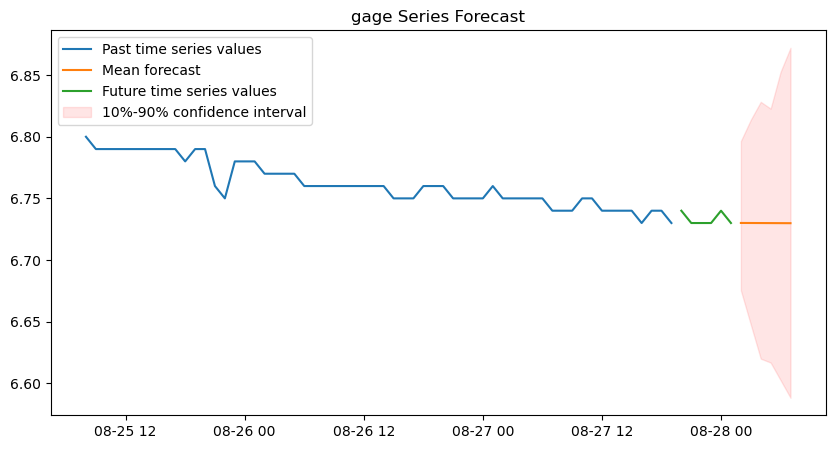

In [25]:
# TimeSeriesDataFrame can also be loaded directly from a file

#test_data = predictions

item_id = 'gage'

plt.figure(figsize=(10, 5))
plt.title(item_id+' Series Forecast')

y_past = train_data.loc[item_id]["series"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["series"]
plt.plot(y_past[-60:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test[-6:], label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend(loc = 'upper left');
plt.savefig(item_id+'_forecast.png')

In [26]:
y_pred[['mean', '0.1', '0.9']]

,mean,0.1,0.9
timestamp,,,
2024-08-28 02:00:00,6.730060,6.675298,6.796542
2024-08-28 03:00:00,6.730021,6.647593,6.813782
2024-08-28 04:00:00,6.729983,6.619961,6.828326
2024-08-28 05:00:00,6.729944,6.616771,6.822827
2024-08-28 06:00:00,6.729906,6.602492,6.852631
2024-08-28 07:00:00,6.729867,6.588222,6.872185


In [27]:
predictions.info()

<class 'autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame'>
MultiIndex: 12 entries, ('gage', Timestamp('2024-08-28 02:00:00')) to ('flow', Timestamp('2024-08-28 07:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mean    12 non-null     float64
 1   0.1     12 non-null     float64
 2   0.2     12 non-null     float64
 3   0.3     12 non-null     float64
 4   0.4     12 non-null     float64
 5   0.5     12 non-null     float64
 6   0.6     12 non-null     float64
 7   0.7     12 non-null     float64
 8   0.8     12 non-null     float64
 9   0.9     12 non-null     float64
dtypes: float64(10)
memory usage: 1.4+ KB
